In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)

In [12]:
#REF: https://github.com/rickiepark/nlp-with-pytorch/blob/main/chapter_3/Chapter-3-Diving-Deep-into-Supervised-Training.ipynb
class Perceptron(nn.Module):
    """ 퍼셉트론은 하나의 선형 층입니다 """

    def __init__(self, input_dim):
        """
        매개변수:
            input_dim (int): 입력 특성의 크기
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """퍼셉트론의 정방향 계산

        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, num_features)입니다.
        반환값:
            결과 텐서. tensor.shape는 (batch,)입니다.
        """
        return torch.sigmoid(self.fc1(x_in))

In [13]:
##data 얻어오기
#REF: https://github.com/rickiepark/nlp-with-pytorch/blob/main/chapter_3/Chapter-3-Diving-Deep-into-Supervised-Training.ipynb
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

In [14]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None,
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]

    colors = ['black', 'white']
    markers = ['o', '*']

    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))

    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)


    xlim = (min([x_list[:,0].min() for x_list in all_x]),
            max([x_list[:,0].max() for x_list in all_x]))

    ylim = (min([x_list[:,1].min() for x_list in all_x]),
            max([x_list[:,1].max() for x_list in all_x]))

    # 초평면

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)

    plt.suptitle(title)

    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

In [26]:
#Adam opt.

import torch.nn
import torch.optim as optim

input_dim = 2
lr = 1e-2

perceptron = Perceptron(input_dim=input_dim)
bce_loss = nn.BCELoss()
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)

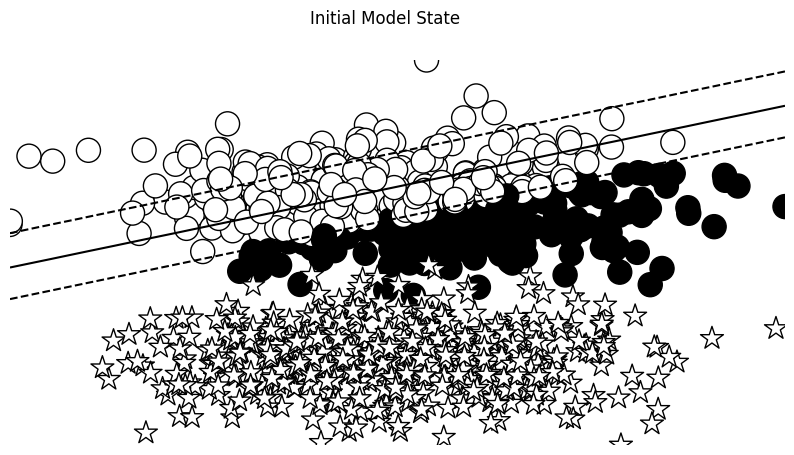

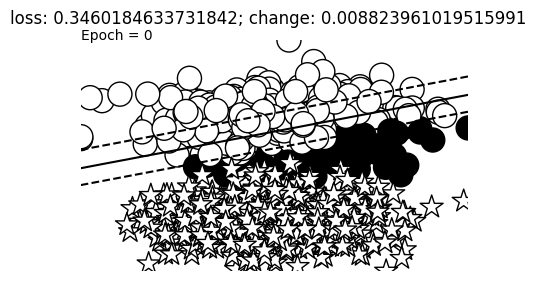

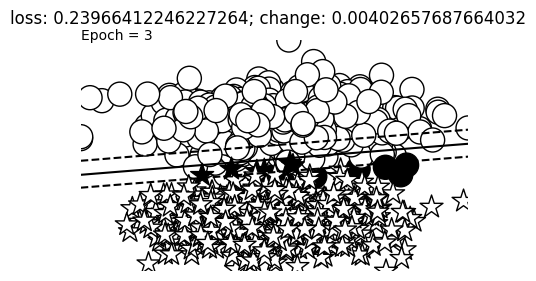

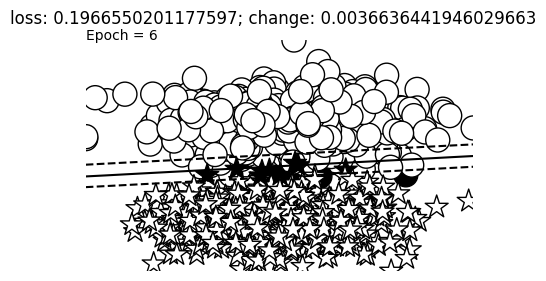

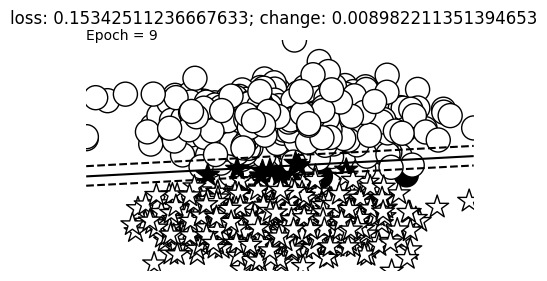

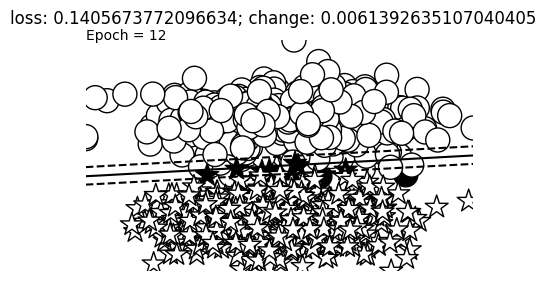

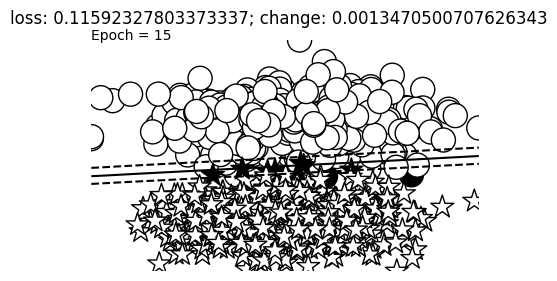

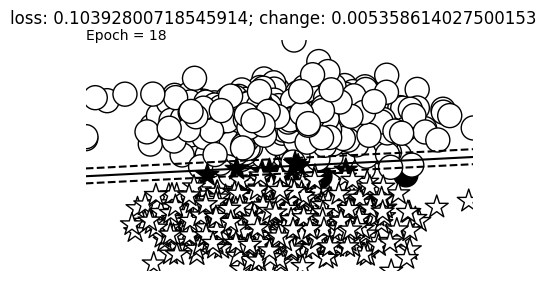

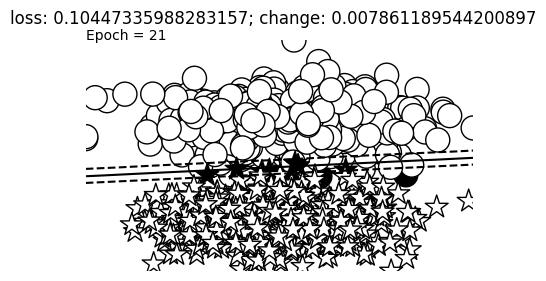

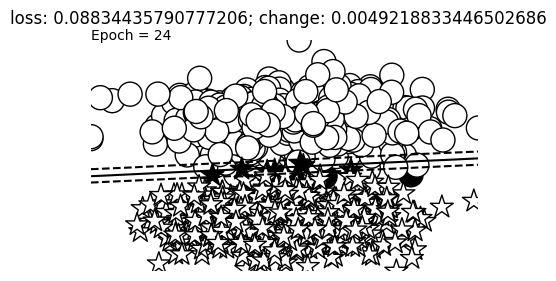

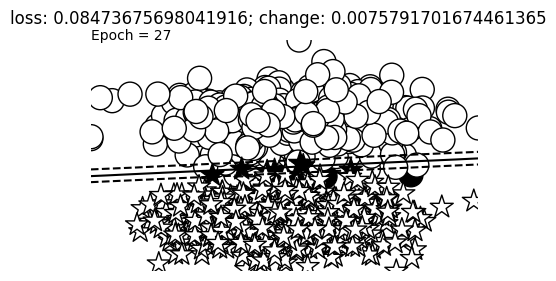

In [27]:
batch_size = 1000
n_epochs = 30
n_batches = 5

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')
epoch = 0
change = 1.0
last = 10.0
epoch = 0
for epoch_i in range(n_epochs):
  for batch_i in range(n_batches):
    x_data, y_target = get_toy_data(batch_size)
    y_target = y_target.reshape(y_target.shape[0], 1)
    perceptron.zero_grad()
    y_pred = perceptron(x_data)
    loss = bce_loss(y_pred, y_target)
    loss.backward()
    optimizer.step()
    loss_value = loss.item()
    change = abs(last - loss_value)
    last = loss_value
  if epoch % 3 == 0:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch,
                      title=f"loss: {loss_value}; change: {change}")
    plt.axis('off')
  epoch+=1